# 0-Libraries

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [97]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [98]:
s_aureus = pd.read_csv('s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


# Preprocessing Data

In [99]:
s_aureus_oxacillin = s_aureus.drop(columns=['code','species', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid'])
s_aureus_oxacillin.dropna(axis=0, how="any", inplace=True)

In [100]:
s_aureus_ceftriaxone = s_aureus.drop(columns=['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Fusidic acid'])
#ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.shape

(3757, 6003)

In [101]:
s_aureus_oxacillin.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.5,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.5,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.5,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.0,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476,1.0


In [102]:
X = s_aureus_oxacillin.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus_oxacillin.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [103]:
s_aureus_oxacillin

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.500000,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.500000,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.500000,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.000000,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.000000,24.990476,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3786,288.000000,330.285714,296.142857,265.142857,310.750000,287.000000,345.000000,260.000000,198.714286,257.285714,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.004038,0.0
3787,1286.142857,989.714286,938.285714,901.428571,872.000000,1001.000000,1061.571429,890.857143,813.857143,961.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.053908,0.0
3788,986.857143,977.285714,892.285714,986.714286,1045.875000,986.857143,963.571429,968.571429,960.857143,969.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.039084,0.0
3789,141.857143,197.428571,148.142857,114.000000,125.857143,158.750000,176.571429,148.285714,149.714286,151.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.012113,0.0


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

## Enfoque en clase minoritaria

In [105]:
minority_class = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].drop(columns=['Oxacillin'])


In [106]:
etiquetas = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].iloc[:, 6000].values

Diffusion model


In [107]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [108]:
scaler = MinMaxScaler()
X_minority_scaled = scaler.fit_transform(minority_class)

In [ ]:
# Dimensiones
input_dim = X_minority_scaled.shape[1]
latent_dim = 2  # Espacio latente

# Encoder
inputs = Input(shape=(input_dim,))
hidden = Dense(16, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(hidden)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden)

# Sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
decoder_hidden = Dense(16, activation='relu')
decoder_output = Dense(input_dim, activation='sigmoid')

hidden_decoded = decoder_hidden(z)
outputs = decoder_output(hidden_decoded)

# Modelo VAE
vae = Model(inputs, outputs)

# Pérdida personalizada
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 6000)]       0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 8)            48008       ['input_11[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 2)            18          ['dense_14[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            18          ['dense_14[0][0]']               
                                                                                            

In [110]:
vae.fit(X_minority_scaled, X_minority_scaled, epochs=200, batch_size=32, verbose=1)


Epoch 1/200
23/23 [==============================] - 1s 7ms/step - loss: 1050.0419
Epoch 2/200
23/23 [==============================] - 0s 5ms/step - loss: 816.2878
Epoch 3/200
23/23 [==============================] - 0s 6ms/step - loss: 563.9810
Epoch 4/200
23/23 [==============================] - 0s 5ms/step - loss: 408.8983
Epoch 5/200
23/23 [==============================] - 0s 6ms/step - loss: 351.0651
Epoch 6/200
23/23 [==============================] - 0s 5ms/step - loss: 297.4052
Epoch 7/200
23/23 [==============================] - 0s 5ms/step - loss: 269.6476
Epoch 8/200
23/23 [==============================] - 0s 6ms/step - loss: 236.1319
Epoch 9/200
23/23 [==============================] - 0s 5ms/step - loss: 211.6721
Epoch 10/200
23/23 [==============================] - 0s 6ms/step - loss: 195.3711
Epoch 11/200
23/23 [==============================] - 0s 6ms/step - loss: 178.9210
Epoch 12/200
23/23 [==============================] - 0s 6ms/step - loss: 157.2304
Epoch 13/200

In [111]:
# Construir el generador (Decoder independiente)
decoder_input = Input(shape=(latent_dim,))
hidden_decoded_2 = decoder_hidden(decoder_input)
output_decoded = decoder_output(hidden_decoded_2)
generator = Model(decoder_input, output_decoded)

# Generar datos sintéticos
num_samples = pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]
latent_points = np.random.normal(size=(num_samples, latent_dim))
synthetic_data = generator.predict(latent_points)

# Escalar de vuelta a los valores originales
synthetic_data_original = scaler.inverse_transform(synthetic_data)


59/59 [==============================] - 0s 1ms/step


In [112]:
pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]

1870

In [113]:
print(pd.Series(y_train).value_counts())

0.0    2451
1.0     581
Name: count, dtype: int64


In [114]:
synthetic_data_original

array([[4288.47    , 4238.809   , 4582.351   , ...,  132.54965 ,
         137.46323 ,  133.9618  ],
       [1222.8639  , 1227.2041  , 1122.6447  , ...,   34.468   ,
          36.66387 ,   35.969604],
       [1527.493   , 1471.1171  , 1501.462   , ...,   78.67247 ,
          82.21929 ,   79.831345],
       ...,
       [1074.2557  , 1026.8855  , 1023.85974 , ...,   60.510223,
          63.21961 ,   61.227474],
       [4544.049   , 4470.626   , 4804.3047  , ...,  123.27856 ,
         128.27834 ,  126.704765],
       [2591.2375  , 2572.4617  , 2585.1187  , ...,   77.41335 ,
          81.823296,   80.4959  ]], dtype=float32)

In [115]:
X_train_balanced = np.concatenate([X_train, synthetic_data_original])
y_train_balanced = np.concatenate([y_train, np.ones(num_samples)])


In [116]:
print(pd.Series(y_train_balanced).value_counts())

1.0    2451
0.0    2451
Name: count, dtype: int64


In [117]:
synthetic_data

array([[0.08131388, 0.08425497, 0.07829522, ..., 0.4500837 , 0.47319528,
        0.46384433],
       [0.02266194, 0.02378999, 0.01876234, ..., 0.11703905, 0.12620954,
        0.12454518],
       [0.02849018, 0.02868711, 0.02528084, ..., 0.2671391 , 0.2830268 ,
        0.27641696],
       ...,
       [0.01981873, 0.01976813, 0.0170625 , ..., 0.20546766, 0.21762344,
        0.21200085],
       [0.08620367, 0.08890923, 0.0821145 , ..., 0.4186029 , 0.44157773,
        0.43871674],
       [0.04884201, 0.05079917, 0.04392786, ..., 0.26286367, 0.28166366,
        0.278718  ]], dtype=float32)

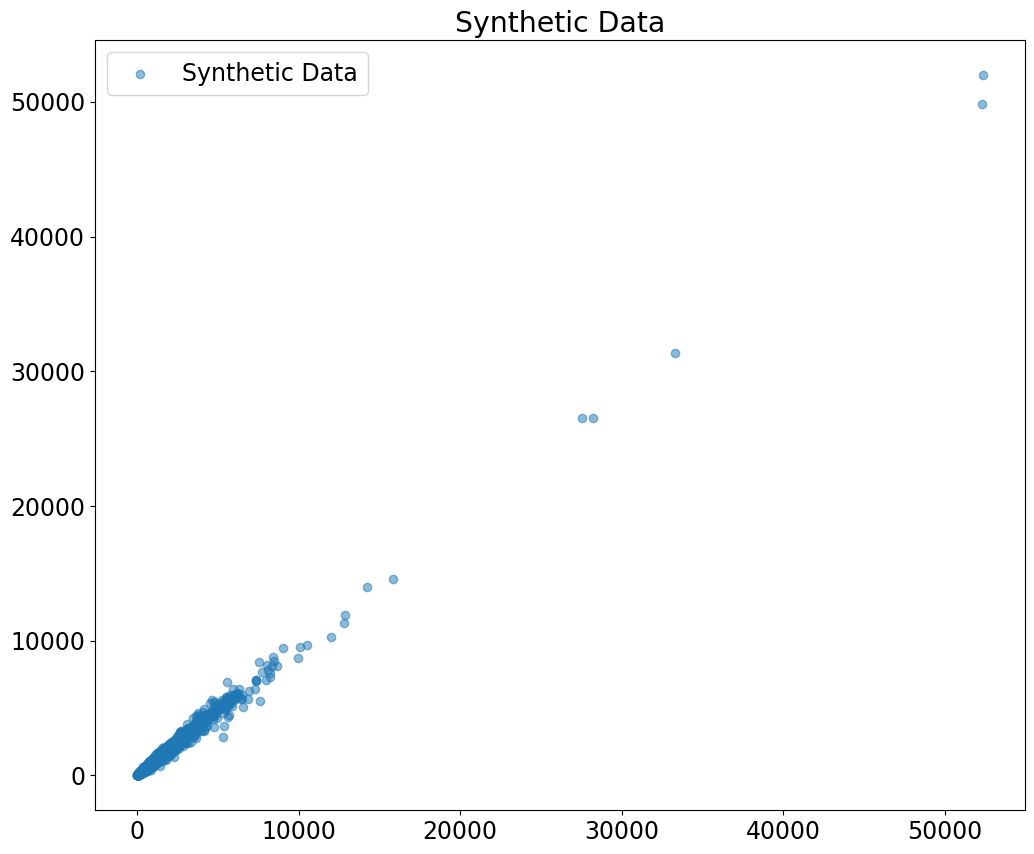

In [118]:
# Visualización
#plt.scatter(minority_class['feature1'], minority_class['feature2'], alpha=0.5, label='Original Data')
plt.scatter(X_train_balanced[:, 0], X_train_balanced[:, 1], alpha=0.5, label='Synthetic Data')
plt.legend()
plt.title('Synthetic Data')
plt.show()

## Termino oversampling

In [119]:
len(X)

3790

In [120]:
len(X_train)

3032

In [121]:
len(y_train)

3032

In [122]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train_balanced)
X_test = sc_X.transform(X_test)

In [123]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [124]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

In [125]:
print(pd.Series(y_train_balanced).value_counts())


1.0    2451
0.0    2451
Name: count, dtype: int64


# Create and fit DeepAMR model

In [126]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization_12 (Bat  (None, 5984, 64)         256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_13 (Bat  (None, 

In [127]:
history = model.fit(X_train_reshaped, y_train_balanced, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100
442/442 [==============================] - 15s 27ms/step - loss: 5.9777 - tp: 1359.0000 - fp: 232.0000 - tn: 2219.0000 - fn: 601.0000 - accuracy: 0.8112 - precision: 0.8542 - recall: 0.6934 - auc: 0.8591 - prc: 0.8720 - val_loss: 5.2448 - val_tp: 488.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 3.0000 - val_accuracy: 0.9939 - val_precision: 1.0000 - val_recall: 0.9939 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 2/100
442/442 [==============================] - 11s 24ms/step - loss: 5.0575 - tp: 1438.0000 - fp: 156.0000 - tn: 2295.0000 - fn: 522.0000 - accuracy: 0.8463 - precision: 0.9021 - recall: 0.7337 - auc: 0.9021 - prc: 0.9141 - val_loss: 4.4240 - val_tp: 491.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 3/100
442/442 [==============================] - 11s 24ms/step - loss: 4.4535 - tp: 15

# Evaluate the model

In [128]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

24/24 [==============================] - 1s 15ms/step
[[594  19]
 [ 48  97]]


In [129]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.8189852056027451


In [130]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       613
           1       0.84      0.67      0.74       145

    accuracy                           0.91       758
   macro avg       0.88      0.82      0.84       758
weighted avg       0.91      0.91      0.91       758

76/76 [==============================] - 1s 7ms/step
loss :  0.7211741209030151
tp :  97.0
fp :  19.0
tn :  594.0
fn :  48.0
accuracy :  0.9116094708442688
precision :  0.8362069129943848
recall :  0.6689655184745789
auc :  0.8727681636810303
prc :  0.7714435458183289



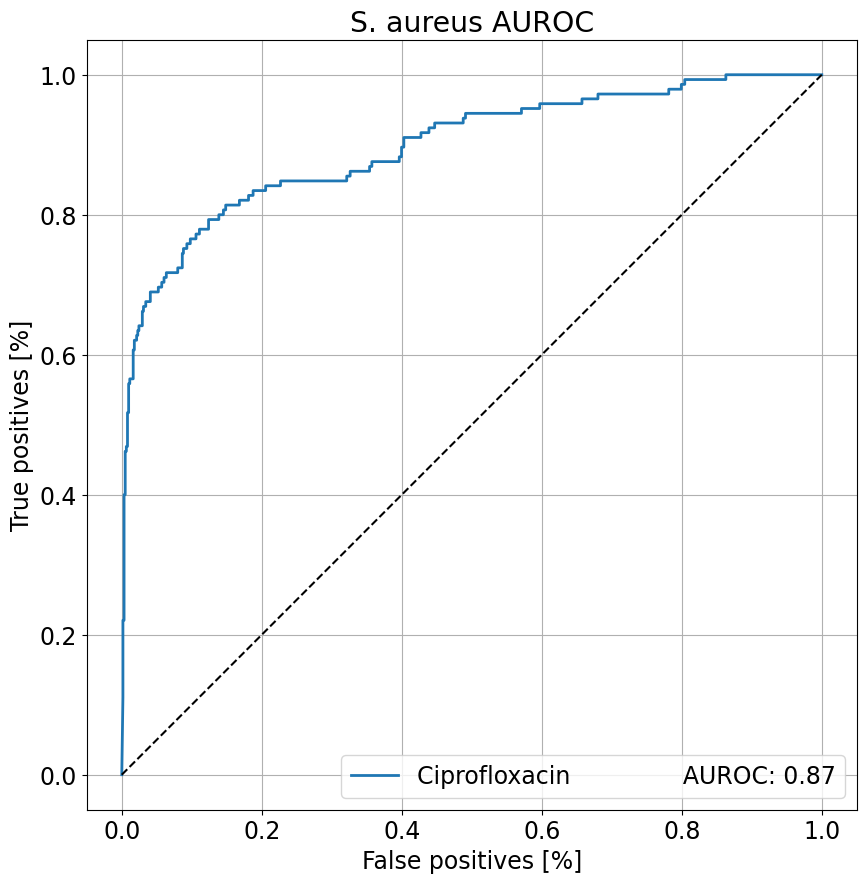

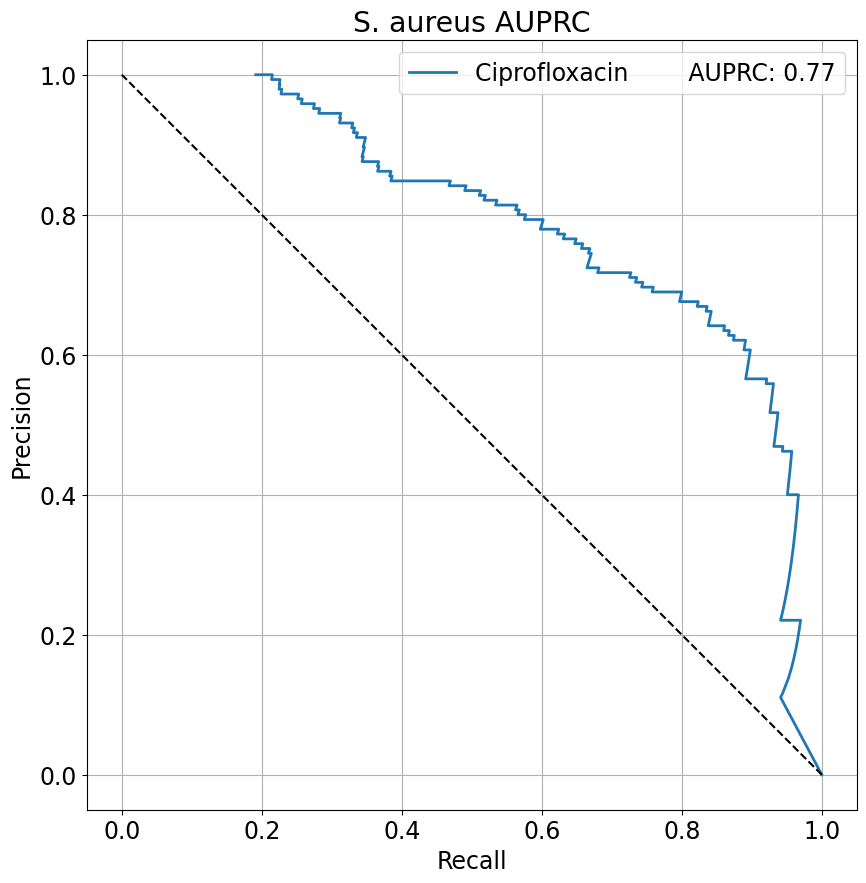

In [131]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()